#3D Object Detection Method - [Automated]
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

------------------------------------
# To-Do
1. Improve create_train_data function
2. Perform callbacks in training

------------------------------------
# Installing dependences

In [ ]:
!pip install deeptrack

In [ ]:
!pip install geopandas

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import cv2
import scipy.io
%matplotlib inline
import numpy as np
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle

------------------------------------
# Creating a class with training and detect functions

In [5]:
class Detector():

  def __init__(self,
               wide,
               scales=[1, 2, 4],
               colors = 'rgb',
               downsample = 1,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1))
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors
    self.model = model
    self.downsample = downsample


  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image
  

  def normalizate(self, image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return normalized_image


  def create_train_data(self, image):
    normalized_image = self.normalizate(image)
    training_image = np.expand_dims(normalized_image, axis = -1)

    train_set =   (
        dt.Value(training_image)
        >> dt.AveragePooling(ksize=(self.downsample, self.downsample, 1))
        #>> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, scale=lambda:np.random.uniform(1, 2, 2))
        #>> dt.Affine(rotate=lambda: np.random.rand()*np.pi*2, translate=lambda:np.random.uniform(-2, 2, 2))
        >> dt.Add(lambda: np.random.randn() * 0.1) # 0.1
        >> dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01))  # Very sensitive
        >> dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) #0.3, 1.6
    )
    train_set.plot()

    return train_set


  def fit(self, train_set, epochs=40, batch_size=8):
    history = self.model.fit(
    train_set,
    epochs = epochs,
    batch_size = batch_size)

    return history


  def plot_performance(self, history):
    #Summarize history for total_loss and consistency_loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])
    # ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()


  def load_images(self, data):
    dataset = [cv2.resize(data, (0, 0), fx=1/scale, fy=1/scale) for scale in self.scales]
    input_set = [self.normalizate(image) for image in dataset]

    fig, ax = plt.subplots(1, len(input_set), figsize=(25,4.5))
    fig.tight_layout()
    fig.suptitle('Scaled 3D images')

    for index in range(len(input_set)):
      ax[index].imshow(input_set[index])
    
    return input_set


  def detect(self, image, alpha = 0.1, cutoff = 0.998, mode = "quantile", color = "r"):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=alpha, beta=1-alpha, cutoff=cutoff, mode="quantile")[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections


  def detect_all(self, images):
    detections = []
    fig, ax = plt.subplots(1, len(images), figsize=(25, 4.5))
    fig.tight_layout()
    fig.suptitle('Detections')
    
    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      ax[index].imshow(images[index])
      ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])
      
    return detections


  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()


  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds


  def plot_boxes(self, test_image, detections):
    list_boxes, list_bounds, scaled_detections = [], [], []

    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds


  def NMSupression(self, boxes, overlapThresh):

    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")


  def apply_nms(self, image, list_bounds, overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections)

    return final_detections

 
  def plot_results(self, image, boxes, color='red', lw=4):
    plt.figure(figsize=(15, 15))
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

-------------------
# Settings

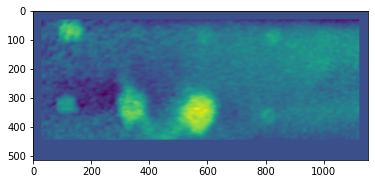

In [13]:
n = 2
train_data = scipy.io.loadmat(f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/data{n}.mat')
train_image = train_data['Spz']
plt.imshow(train_image)

In [7]:
size_object = 100
downsample = size_object // 50 # 50 is a good size for the training
wide = size_object / downsample

In [8]:
detector = Detector(wide=wide,
                    scales = [1,2,4],
                    downsample=downsample)

---------------
# Option A: Training

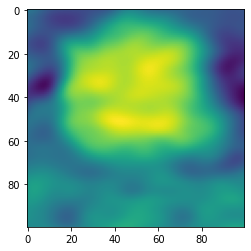

In [9]:
x, y = (65, 285)
crop = detector.crop(train_image, x, y, size_object)
plt.imshow(crop)

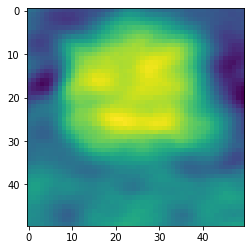

In [10]:
train_set = detector.create_train_data(crop)

In [11]:
history = detector.fit(train_set, epochs=50)

Generating 161 / 160 samples before starting training
Epoch 1/50
161/161 [==============================] - 15s 12ms/step - total_loss: 2.4779 - consistency_loss: 1.5013
Epoch 2/50
161/161 [==============================] - 8s 52ms/step - total_loss: 1.3348 - consistency_loss: 0.8702                                        
Epoch 3/50
161/161 [==============================] - 9s 54ms/step - total_loss: 0.9031 - consistency_loss: 0.7209                                        
Epoch 4/50
161/161 [==============================] - 6s 40ms/step - total_loss: 1.1239 - consistency_loss: 0.8353                                       
Epoch 5/50
161/161 [==============================] - 9s 54ms/step - total_loss: 0.9471 - consistency_loss: 0.7770                                        
Epoch 6/50
161/161 [==============================] - 7s 42ms/step - total_loss: 0.8495 - consistency_loss: 0.7207                                       
Epoch 7/50
161/161 [==============================] - 9s 

In [14]:
# Save the weights
detector.model.save_weights('/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint')

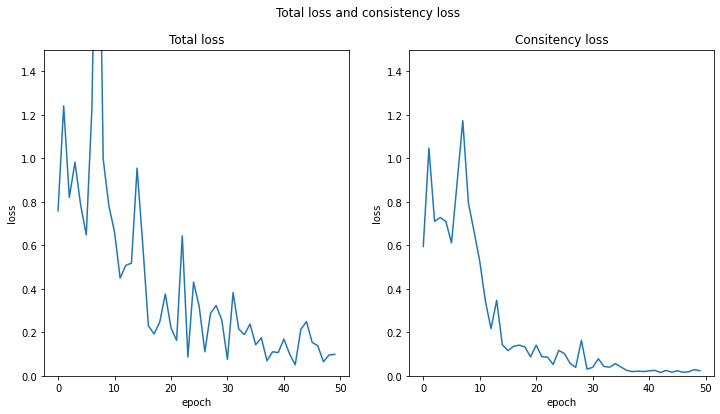

In [15]:
detector.plot_performance(history)

------------------------------------
# Option B: Loading weights

In [ ]:
detector.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
detector.model.load_weights('/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint')

-----------------
# Test

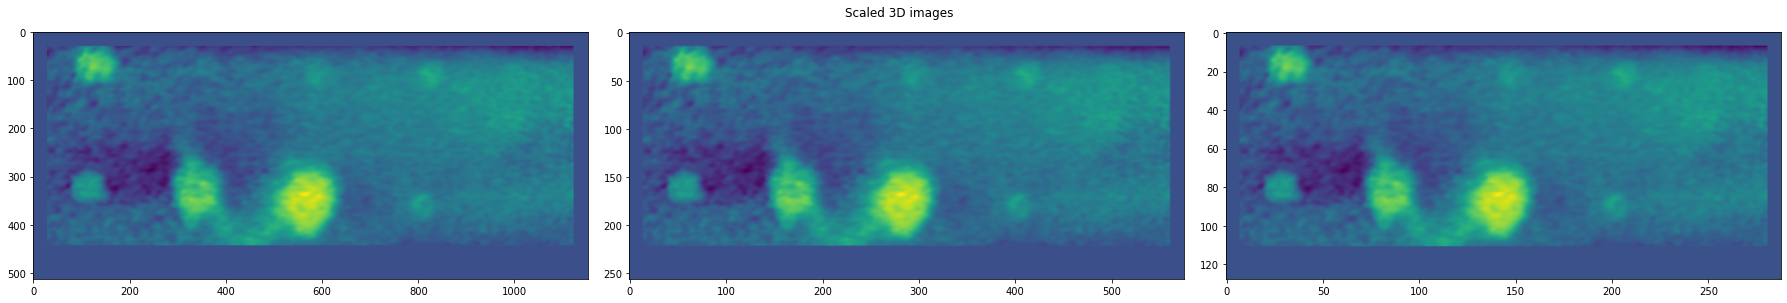

In [58]:
m = 2
test_data = scipy.io.loadmat(f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/data{m}.mat')
input_set = detector.load_images(test_data['Spz'])

1/1 [==============================] - 0s 20ms/step


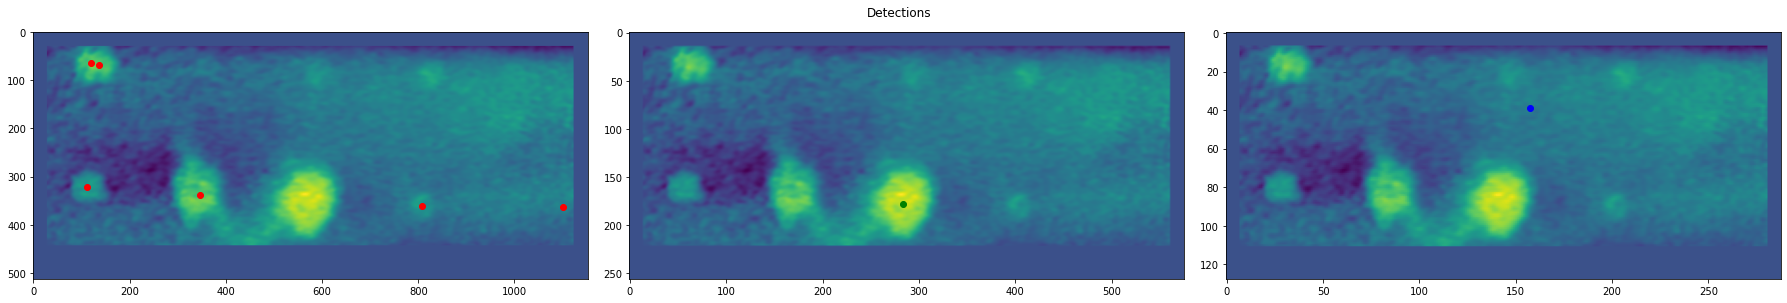

In [59]:
detections = detector.detect_all(input_set)

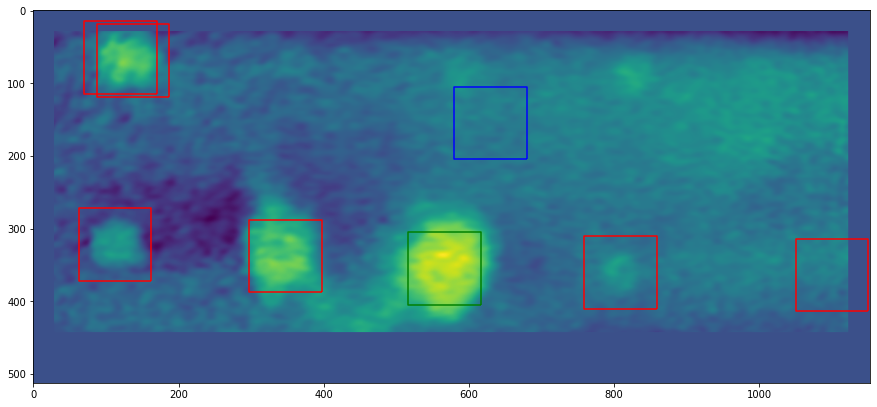

In [60]:
test_image = input_set[0]
bounds = detector.plot_boxes(test_image, detections)

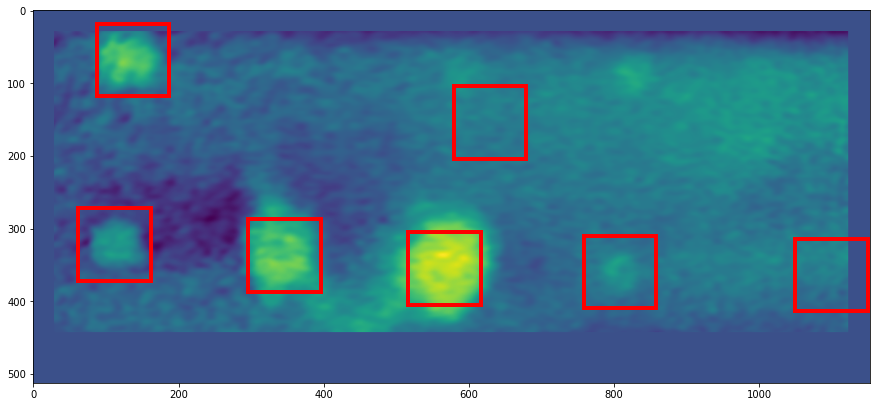

In [61]:
final_detections = detector.apply_nms(test_image, bounds)

--------------------------------
# Test 2 - Using one upsampling image

In [62]:
up_detector = Detector(wide=wide,
                    scales = [1, 2, 4], # [0.5, 1, 2]
                    downsample=downsample)

In [63]:
dataset = cv2.resize(test_data['Spz'], (0, 0), fx=2, fy=2)

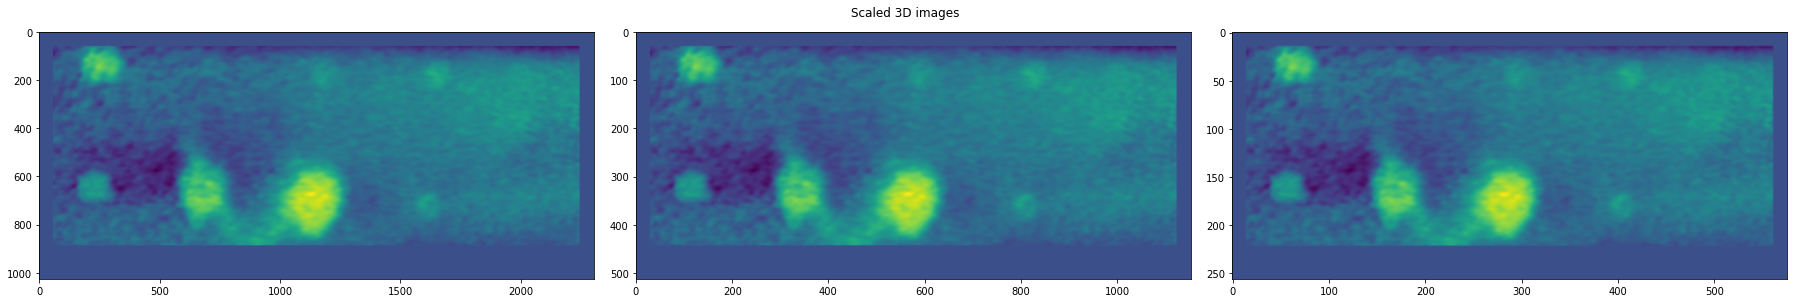

In [64]:
up_input_set = up_detector.load_images(dataset)

In [65]:
up_detector.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
up_detector.model.load_weights('/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint')

1/1 [==============================] - 0s 42ms/step


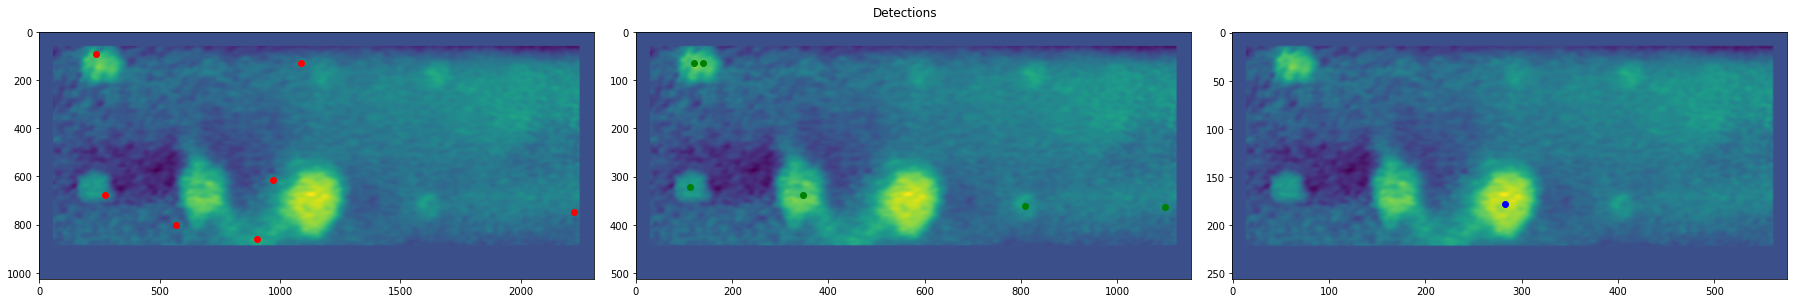

In [66]:
up_detections = up_detector.detect_all(up_input_set)

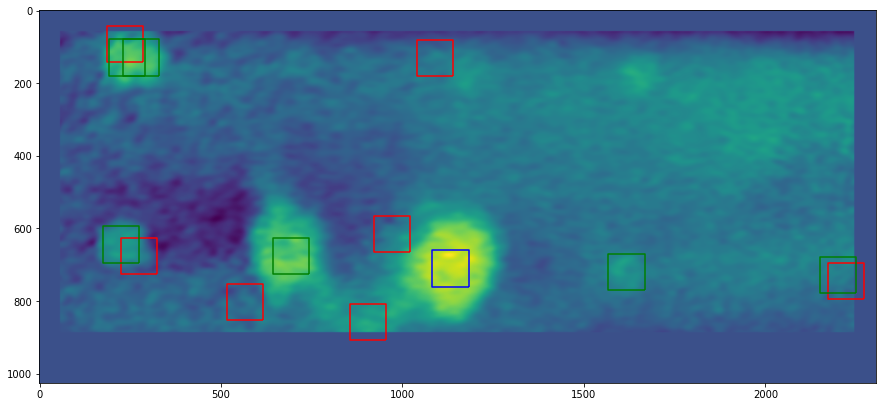

In [67]:
up_test_image = up_input_set[0]
up_bounds = up_detector.plot_boxes(up_test_image, up_detections)

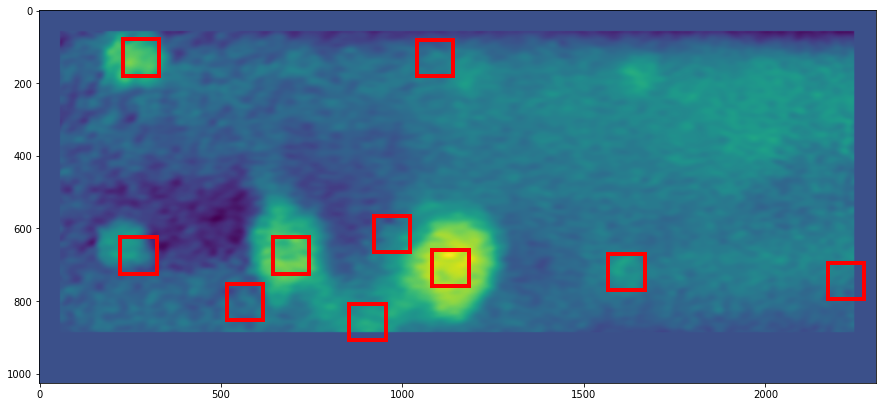

In [68]:
up_final_detections = up_detector.apply_nms(up_test_image, up_bounds, overlapThresh=0.3)